# Предсказание оттока клиентов в телекоммуникационной компании

Описание проекта: оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.
    
Цель исследования: построить модель для предсказания оттока клиента.
    
Ход исследования:
    
    Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов
    
    Предобработка данных: обработка пропущенных значений, удаление дубликатов и т.д.
    
    Исследовательский анализ данных: статистический анализ всех признаков
    
    Объединение данных: объединение выбранных признаков в один датафрейм по ключу
    
    Исследовательский анализ и предобработка данных объединённого датафрейма: распределение признаков в новом датафрейме, корреляционный анализ
    
    Кодировка данных: кодировка данных с помощью пайплайна
    
    Обучение моделей: обучение двух моделей и выбор лучшей из них по метрике ROC-AUC
    
    Вывод: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.
    

## Подготовка данных

Импортирую все библиотеки в отдельной ячейке

In [1]:
!pip install numpy==1.26.4
!pip install --upgrade scipy numba
!pip install matplotlib==3.7.3
!pip list
!pip install imblearn
import numpy
import matplotlib

Package                           Version
--------------------------------- -------------------
absl-py                           1.2.0
alembic                           1.6.5
anyio                             3.2.1
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.9.3
bleach                            3.3.0
blinker                           1.4
blis                              0.7.8
branca                            0.5.0
brotlipy                          0.7.0
cachetools                        5.2.0
catalogue                         2.0.8
catboost                          1.0.3
certifi                           2022.6.15
certipy                           0.1.3
cffi                              1.14.5
chardet             

In [2]:
!pip install phik -q 
!pip install shap
!pip install eli5 -q
!pip install -U scikit-learn -q
import matplotlib.pyplot as plt
import phik
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import(
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from imblearn.metrics import specificity_score
from sklearn.linear_model import(
    LogisticRegression
)
from sklearn.tree import(
    DecisionTreeClassifier
)
from catboost import CatBoostClassifier
from sklearn.model_selection import(
    GridSearchCV,
)
from sklearn.dummy import DummyClassifier

RANDOM_STATE=20625

Теперь прознакомлюсь с предоставленными датасетами

In [3]:
contract=pd.read_csv('/datasets/contract_new.csv')
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Сразу замечу отсутствие пропусков, а также неправильный тип данных в столбце TotalCharges и в столбцах BeginDate и EndDate

In [4]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['BeginDate']=pd.to_datetime(contract['BeginDate'], errors='coerce')
contract.info()
nan= contract[contract['TotalCharges'].isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


С пропусками и неправильными типами разберусь в предобработке данных
    

In [9]:
internet=pd.read_csv('/datasets/internet_new.csv')
internet=internet[~internet['customerID'].isin(nan)]
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 387.9+ KB


Интернетом компании пользуются 5517 пользователей

In [10]:
phone=pd.read_csv('/datasets/phone_new.csv')
phone=phone[~phone['customerID'].isin(nan)]
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB


Стационарной телефонной связью пользуются 6361 пользователь

## Предобработка данных

Проверю данные на наличие дубликатов в столбце customerID

In [11]:
sum(contract.duplicated(subset=['customerID']))

0

In [12]:
sum(personal.duplicated(subset=['customerID']))

0

In [13]:
sum(internet.duplicated(subset=['customerID']))

0

In [14]:
sum(phone.duplicated(subset=['customerID']))

0

Найду, чем связаны клиенты, у которых пропущены значения в `TotalCharges`. 
    

In [15]:
t=nan['customerID']
nan

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Все клиенты, у которых пропуски в TotalCharges, зарегистрировались в день выгрузки, поэтому система еще не успела присвоить им значения в TotalCharges. Тогда присвою этим клиентам значения из столбца MonthlyCharges

In [16]:
contract['TotalCharges'] = contract.apply(
    lambda row: row['MonthlyCharges'] if np.isnan(row['TotalCharges']) else row['TotalCharges'],
    axis=1
)

In [17]:
contract[contract['customerID'].isin(t)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35


## Исследовательский анализ датафреймов

### Датафрейм contract

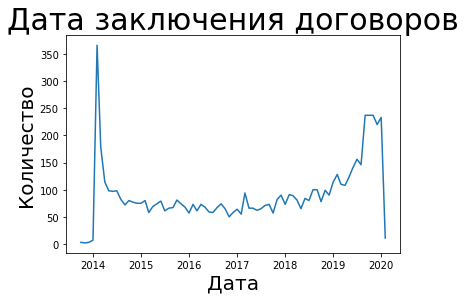

In [18]:
y=contract['BeginDate'].value_counts()
y = contract['BeginDate'].value_counts().reset_index()
y.columns = ['BeginDate', 'Counts']  
y = y.sort_values('BeginDate')
sns.lineplot(data=y, x='BeginDate', y='Counts')
plt.title('Дата заключения договоров',fontsize=30)
plt.xlabel('Дата',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Замечу, что большинство пользователей заключили договор в 2014 году, также небольшой всплеск произошел в середине 2019 года

         index  EndDate
0           No     5942
1   2020-01-01       39
2   2019-12-01       38
3   2018-11-01       35
4   2019-09-01       32
..         ...      ...
62  2015-04-01        2
63  2014-09-01        2
64  2014-11-01        1
65  2014-10-01        1
66  2014-06-01        1

[67 rows x 2 columns]


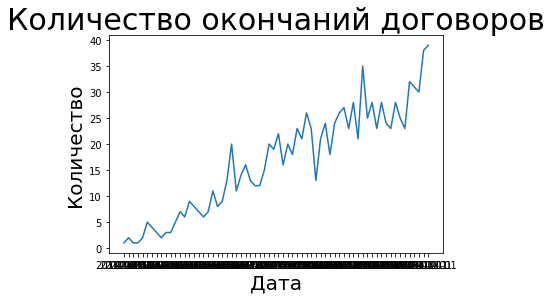

In [19]:
y=contract['EndDate'].value_counts()
y = contract['EndDate'].value_counts().reset_index()
print(y)
y.columns = ['EndDate', 'Counts']
y=y[y['EndDate']!='No']
y = y.sort_values('EndDate')
sns.lineplot(data=y, x='EndDate', y='Counts')
plt.title('Количество окончаний договоров',fontsize=30)
plt.xlabel('Дата',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Подавляющее большинство пользователей продолжает пользоваться услугами "Теледома", однако в последнее время число пользователей, отказывающихся от их услуг, растет

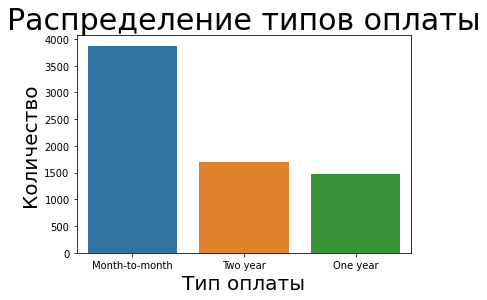

In [20]:
y = contract['Type'].value_counts().reset_index()
y.columns = ['Type', 'Counts']
sns.barplot(data=y,x='Type',y='Counts')
plt.title('Распределение типов оплаты',fontsize=30)
plt.xlabel('Тип оплаты',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Большинство пользователей пользуются ежемесячной оплатой, что логично, ведь всегда можно отказаться от услуг, не заплатив предварительно много денег

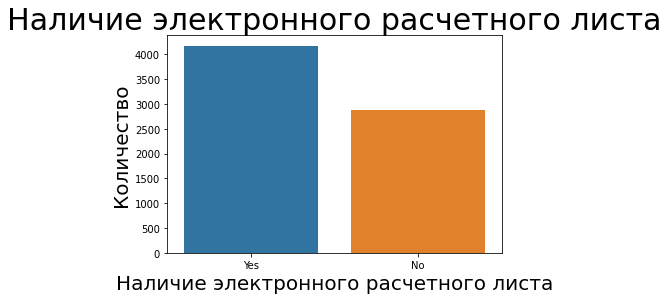

In [21]:
y = contract['PaperlessBilling'].value_counts().reset_index()
y.columns = ['PaperlessBilling', 'Counts']
sns.barplot(data=y,x='PaperlessBilling',y='Counts')
plt.title('Наличие электронного расчетного листа',fontsize=30)
plt.xlabel('Наличие электронного расчетного листа',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Электронный расчетный лист нужен примерно 60% пользователей

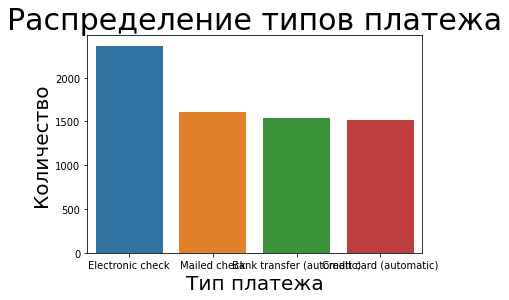

In [22]:
y = contract['PaymentMethod'].value_counts().reset_index()
y.columns = ['PaymentMethod', 'Counts']
sns.barplot(data=y,x='PaymentMethod',y='Counts')
plt.title('Распределение типов платежа',fontsize=30)
plt.xlabel('Тип платежа',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Самый популярный способ платежа-электронный чек, остальные типы оплаты пользуются одинаковой популярностью

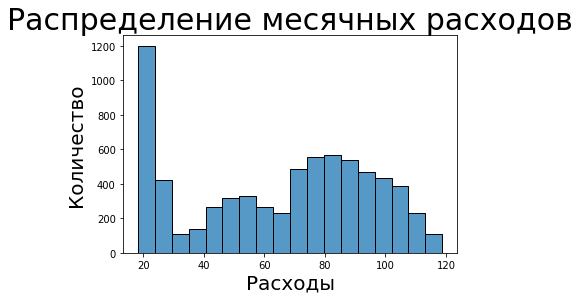

In [23]:
sns.histplot(data=contract,x='MonthlyCharges')
plt.title('Распределение месячных расходов',fontsize=30)
plt.xlabel('Расходы',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Месячные расходы пользователей зачастую не превышают 20 долларов, однако около 3000 пользователей тратят 80 долларов и больше

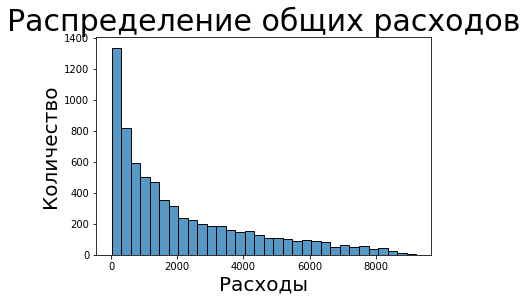

In [24]:
sns.histplot(data=contract,x='TotalCharges')
plt.title('Распределение общих расходов',fontsize=30)
plt.xlabel('Расходы',fontsize=20)
plt.ylabel('Количество',fontsize=20)
plt.show()

Скорее всего такая картина складывается из-за того, что многие пользуются помесячной оплатой, и их расходы суммарно получаются меньше, чем у людей, которые предварительно заплатили за год вперед. Доходность клиентов обратно пропорциональна количеству.

### Датафрейм personal

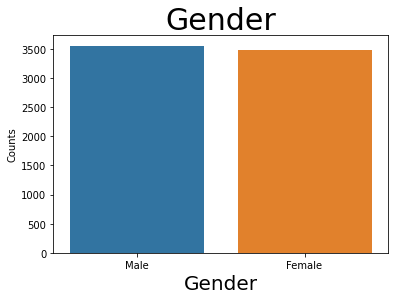

In [25]:
y = personal['gender'].value_counts().reset_index()
y.columns = ['gender', 'Counts']
sns.barplot(data=y,x='gender',y='Counts')
plt.title('Gender',fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.show()

Количество мужчин и женщин практически одинаково, мужчин больше совсем чуть-чуть

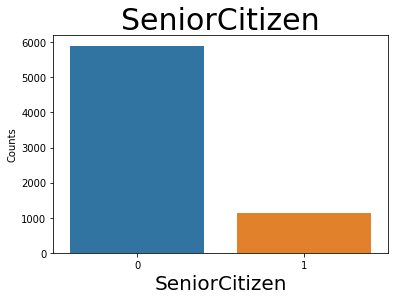

In [26]:
y = personal['SeniorCitizen'].value_counts().reset_index()
y.columns = ['SeniorCitizen', 'Counts']
sns.barplot(data=y,x='SeniorCitizen',y='Counts')
plt.title('SeniorCitizen',fontsize=30)
plt.xlabel('SeniorCitizen',fontsize=20)
plt.show()

Пенсионеров среди клиентов примерно в 6 раз меньше, чем всех остальных

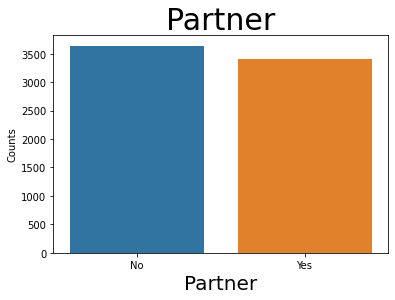

In [27]:
y = personal['Partner'].value_counts().reset_index()
y.columns = ['Partner', 'Counts']
sns.barplot(data=y,x='Partner',y='Counts')
plt.title('Partner',fontsize=30)
plt.xlabel('Partner',fontsize=20)
plt.show()

Чуть меньше половины пользователей состоит в браке

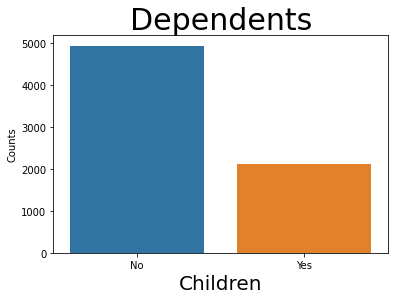

In [28]:
y = personal['Dependents'].value_counts().reset_index()
y.columns = ['Dependents', 'Counts']
sns.barplot(data=y,x='Dependents',y='Counts')
plt.title('Dependents',fontsize=30)
plt.xlabel('Children',fontsize=20)
plt.show()

Пользователей без детей больше примерно в 2.5 раза

### Датафрейм internet

In [29]:
def graphik(data,x,y,axes,i):
    sns.barplot(ax=axes,data=data,x=x,y=y)

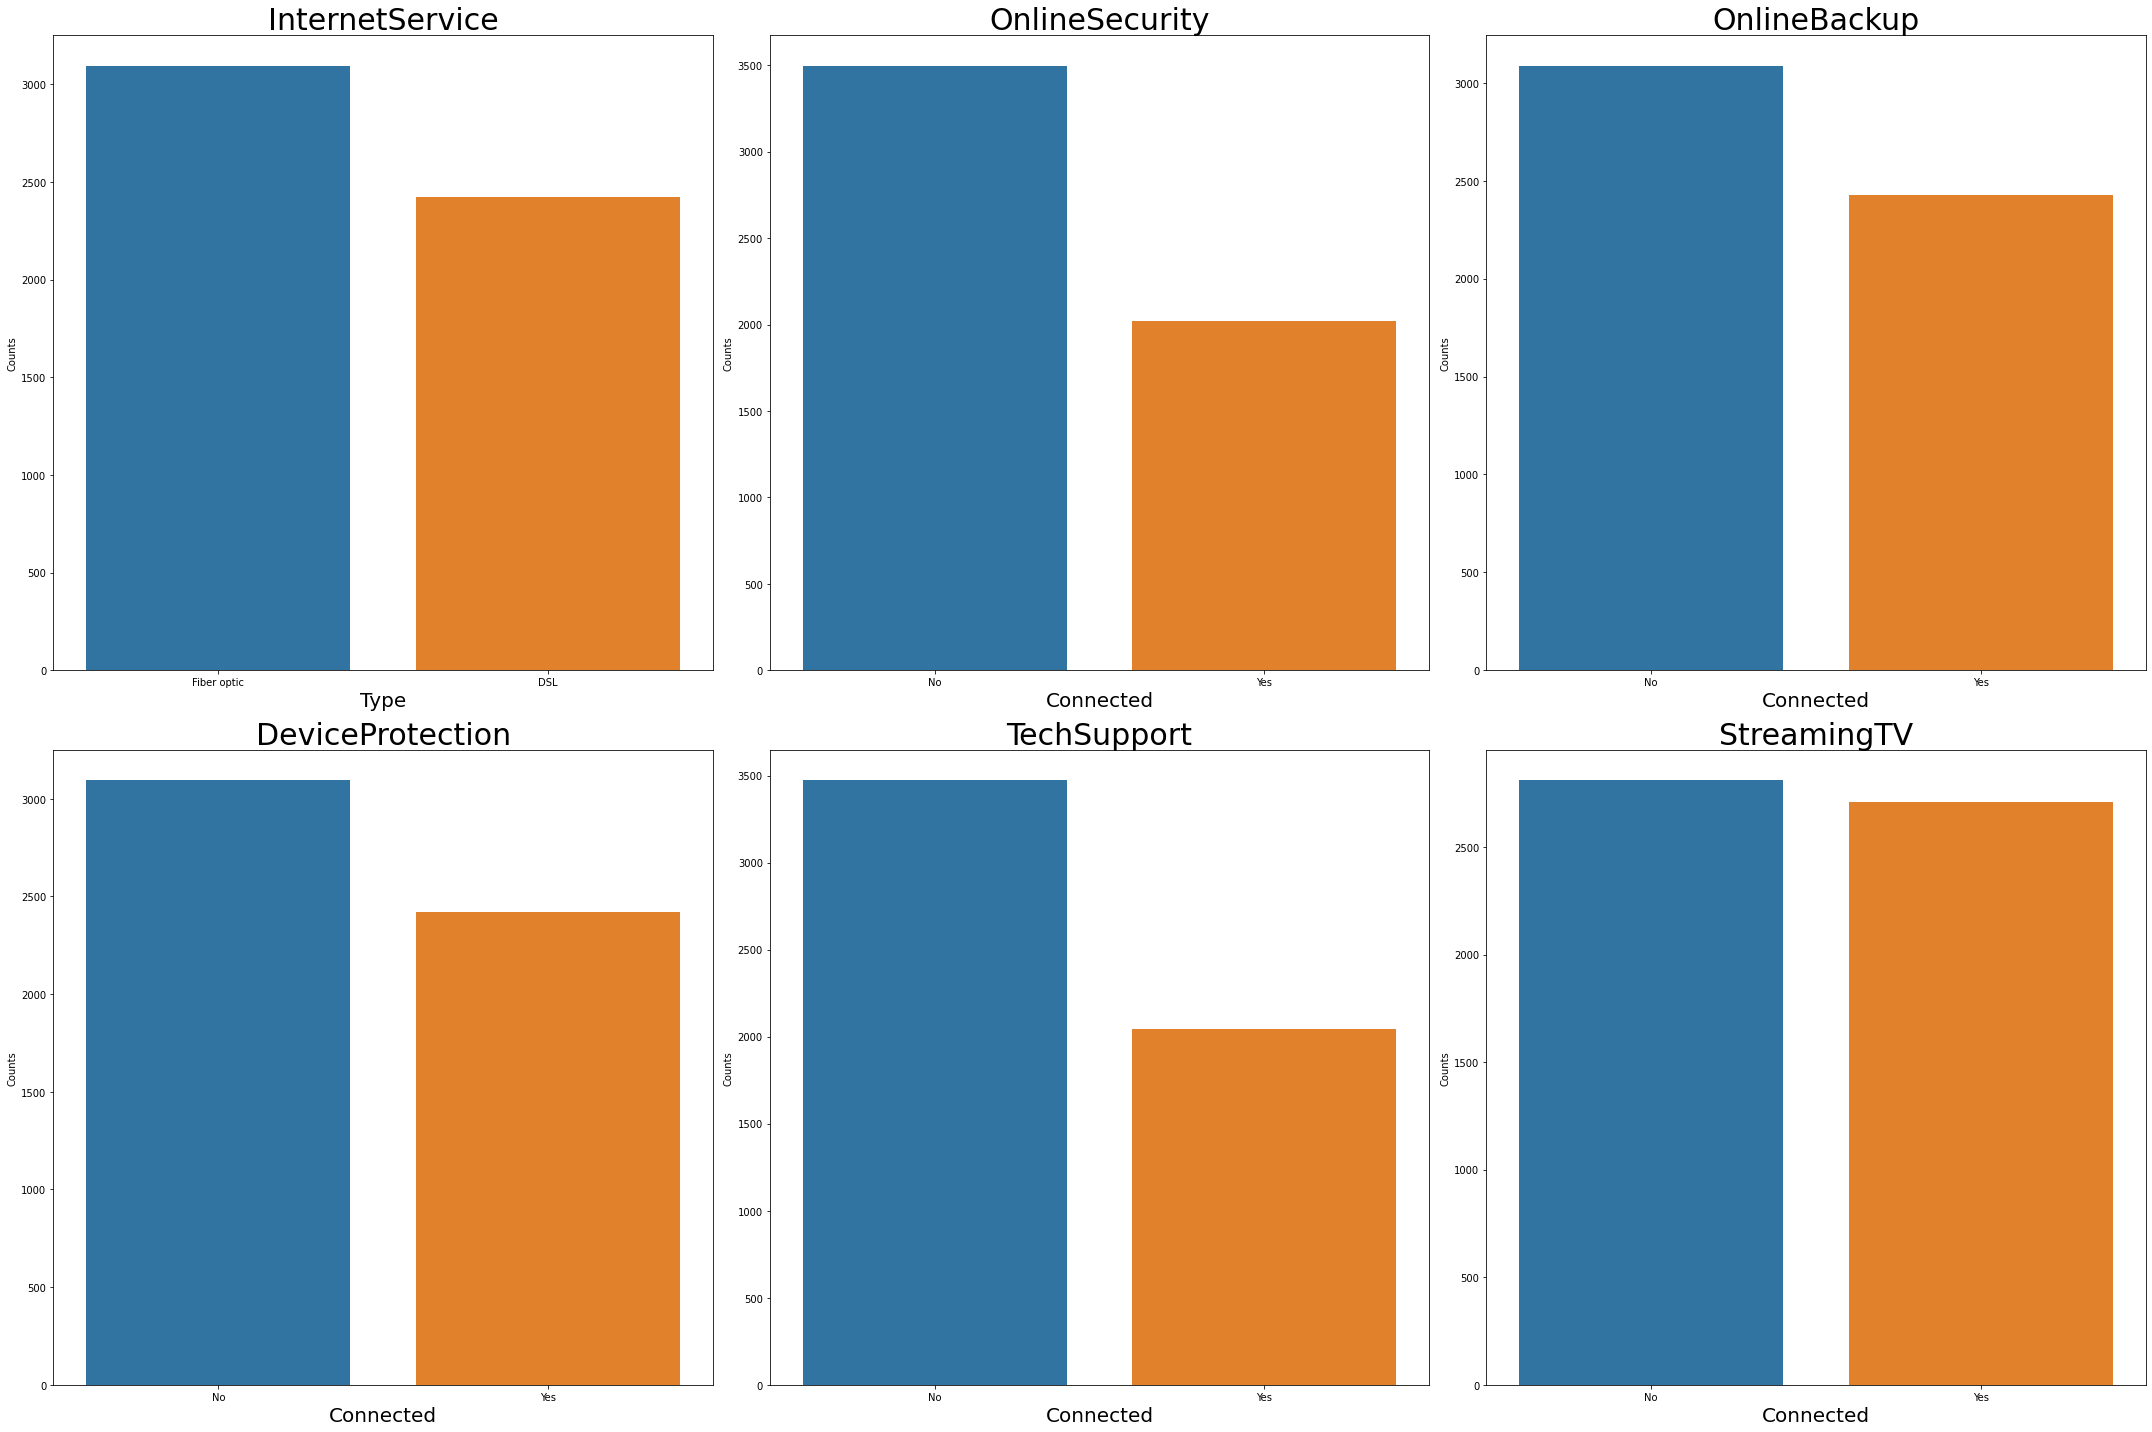

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
axes = axes.flatten()
features=internet.drop(columns=['customerID','StreamingMovies']).columns
for i,feature in enumerate(features):
    y = internet[feature].value_counts().reset_index()
    y.columns = [feature, 'Counts']
    graphik(y,feature,'Counts',axes[i],feature)
    axes[i].set_title(feature,fontsize=30)
    if feature=='InternetService':
        axes[i].set_xlabel("Type",fontsize=20)
        continue
    axes[i].set_xlabel("Connected",fontsize=20)
plt.tight_layout() 
plt.show()

Пользователи чаще пользуются подключением через оптоволоконный кабель, однако также много и тех, кто подключен через телефонную линию(почти 2500 значений)

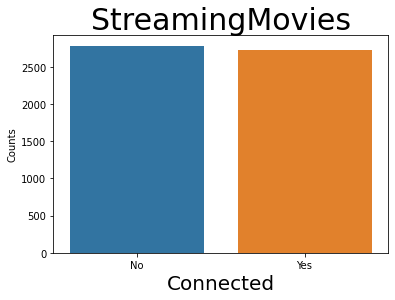

In [31]:
y = internet['StreamingMovies'].value_counts().reset_index()
y.columns = ['StreamingMovies', 'Counts']
sns.barplot(data=y,x='StreamingMovies',y='Counts')
plt.title('StreamingMovies',fontsize=30)
plt.xlabel('Connected',fontsize=20)
plt.show()

Клиенты чаще пользуются соединением через оптоволоконный кабель, чем через телефонную линию. Чаще всего абоненты игнорируют защиту от безопасных сайтов и не пользуются выделенной линией техподдержки. По остальныи признакам наблюдается паритет.

### Датафрейм phone

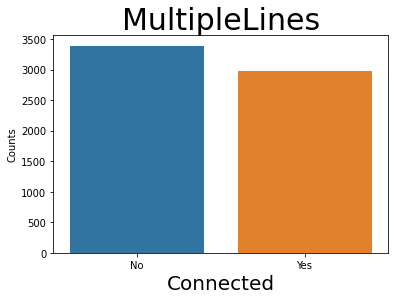

In [32]:
y = phone['MultipleLines'].value_counts().reset_index()
y.columns = ['MultipleLines', 'Counts']
sns.barplot(data=y,x='MultipleLines',y='Counts')
plt.title('MultipleLines',fontsize=30)
plt.xlabel('Connected',fontsize=20)
plt.show()

Чуть больше половины пользователей подключены к нескольким телефонным линиям одновременно

## Объединение данных

Объединю все датафреймы по одному общему ключу-customerID

In [33]:
common=pd.merge(contract,personal,on='customerID',how='outer')
common=pd.merge(common,internet,on='customerID',how='outer')
common=pd.merge(common,phone,on='customerID',how='outer')

In [34]:
common.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Изменю тип данных в столбце SeniorCitizen

In [35]:
personal['SeniorCitizen']=personal['SeniorCitizen'].astype(object)

## Исследовательский анализ и предобработка данных объединённого датафрейма

Все образовавшиеся пропуски стоит заменить на значение missing, поскольку, если при объединении данных id пользователя не обнаружено в таблице internet или phone, значит он пользуется услугами другого типа.

In [36]:
common=common.fillna('missing')
common.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,missing
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,missing
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Теперь проведу корреляционный анализ, добавлю признак contract_duration, чтобы Phik matrix могла корректно обрабатывать даты, также добавлю целевой признак- является ли клиент действующим, или нет.

In [37]:
common['client_gone'] = (common['EndDate'] != 'No').astype(int)

In [38]:
common['EndDate']=pd.to_datetime(common['EndDate'], errors='coerce')
common['EndDate']=common['EndDate'].fillna('2020-02-01')
common['EndDate'] = pd.to_datetime(common['EndDate'])  
common['contract_duration'] = (common['EndDate'] - common['BeginDate']).dt.days
common.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_gone,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,missing,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,missing,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [39]:
matrix=(common.drop(columns=['customerID','BeginDate','EndDate']).phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','contract_duration']))

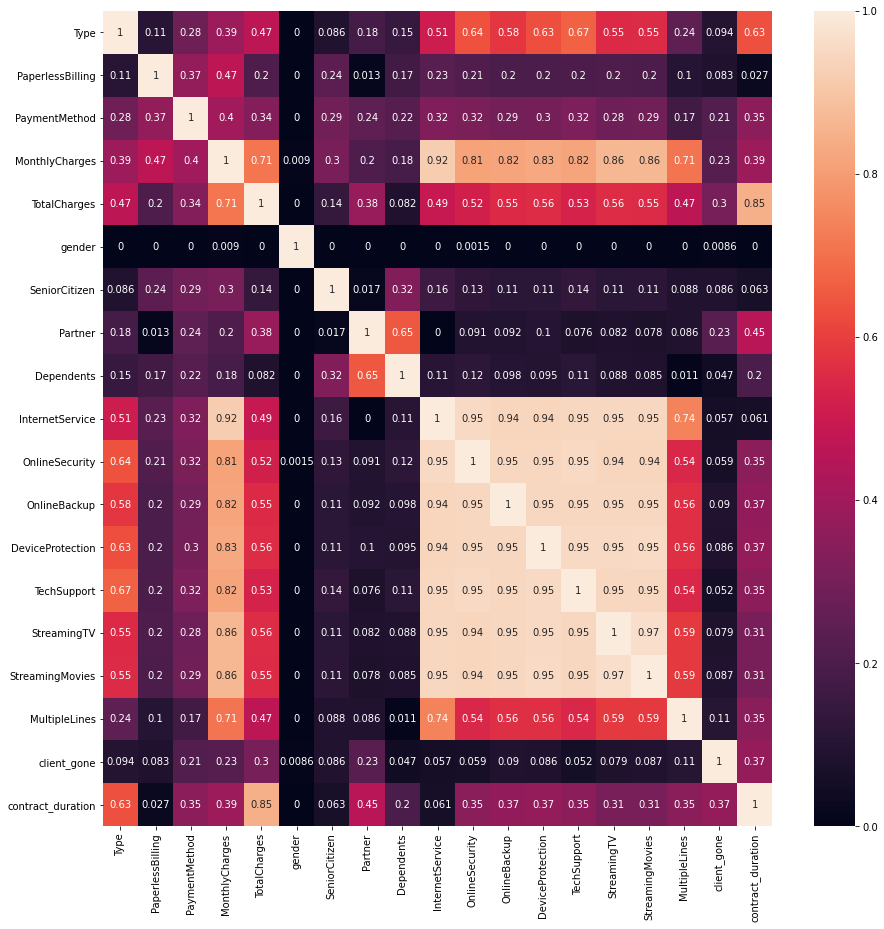

In [40]:
plt.figure(figsize=(15,15))
sns.heatmap(matrix,annot=True)
plt.show()

Сразу отмечу сильную корреляцию между признаками из датафрейма internet: если один их них missing, то missing и все остальные.
На целевой признак сильнее всего влияют contract_duration и TotalCharges. Признаки TotalCharges и MonthlyCharges также сильно коррелирут с InternetService,OnlineSecurity и тд, поскольку наличие дополнительных услуг подразумевает дополнительную плату. Признак Type тоже коррелирует с признаками из Internet, так как он напрямую определяет возможность использования определенных дополнительных услуг. Признак contract_duration коррелирует с TotalCharges(поскольку чем дольше клиент пользуется услугами, тем больше он платит), а также с Type.

Визуализирую распределения нескольких признаков

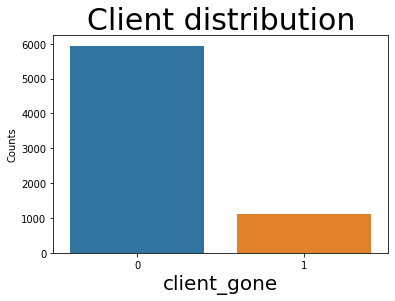

In [41]:
y = common['client_gone'].value_counts().reset_index()
y.columns = ['client_gone', 'Counts']
sns.barplot(data=y,x='client_gone',y='Counts')
plt.title('Client distribution',fontsize=30)
plt.xlabel('client_gone',fontsize=20)
plt.show()

Отмечу, что работать предстоит с явным дисбалансом классов, поэтому учту это в будущих этапах

Рассмотрю теперь распределение месячных расходов среди тех, кто пользуется только интернетом компании и среди тех, кто пользуется только телефонной связью

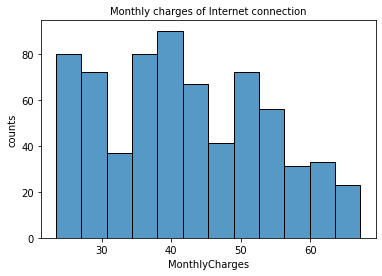

In [42]:
sns.histplot(data=common[common['MultipleLines']=='missing'],x='MonthlyCharges')
plt.title('Monthly charges of Internet connection',fontsize=10)
plt.xlabel('MonthlyCharges',fontsize=10)
plt.ylabel('counts',fontsize=10)
plt.show()

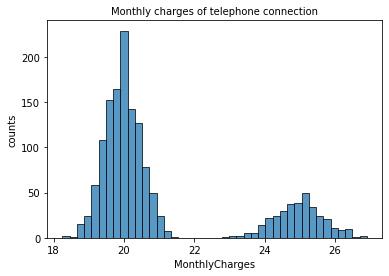

In [43]:
sns.histplot(data=common[common['InternetService']=='missing'],x='MonthlyCharges')
plt.title('Monthly charges of telephone connection',fontsize=10)
plt.xlabel('MonthlyCharges',fontsize=10)
plt.ylabel('counts',fontsize=10)
plt.show()

Можно заметить, что стоимость услуг стационарной телефонной связи сильно дешевле, чем стоимость интернета

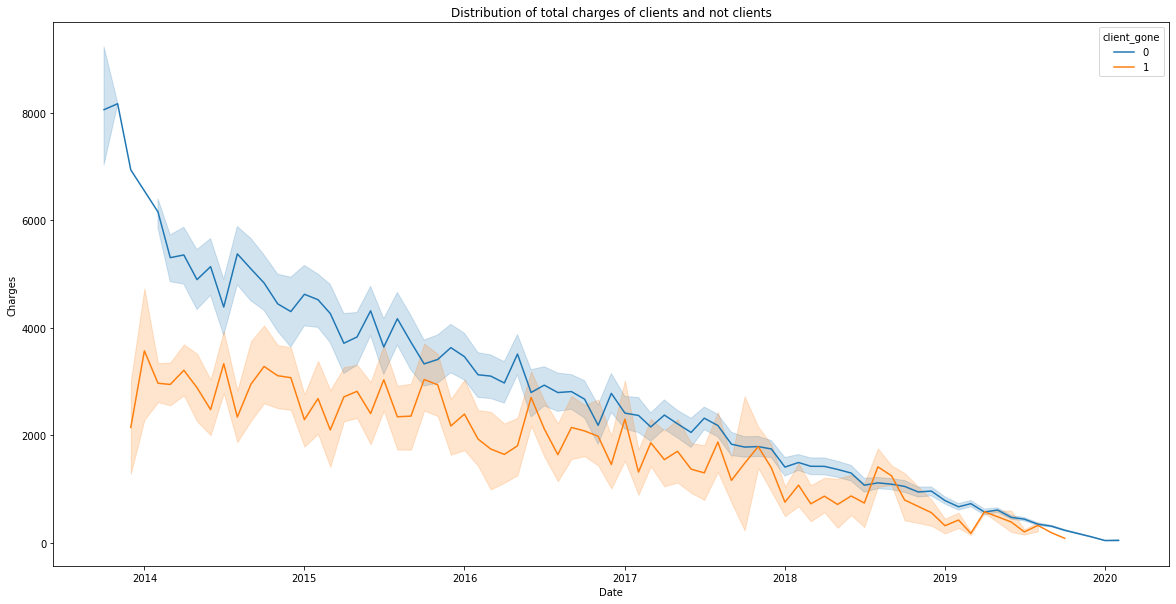

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=common, x='BeginDate', y='TotalCharges', hue='client_gone')
plt.title('Distribution of total charges of clients and not clients')
plt.xlabel('Date')
plt.ylabel('Charges')
plt.show()

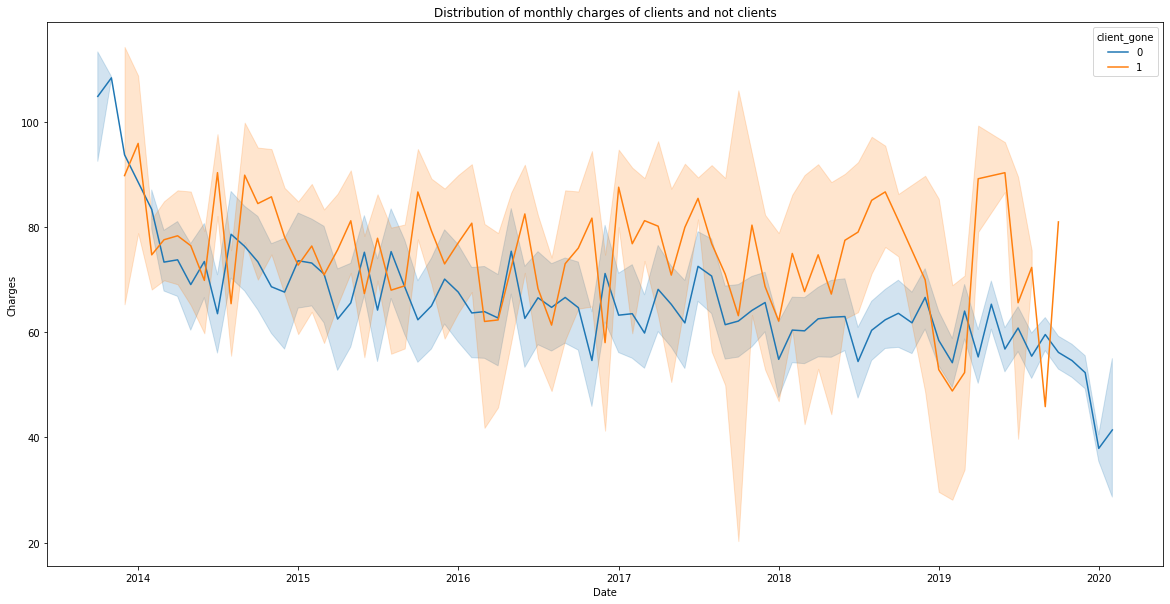

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=common, x='BeginDate', y='MonthlyCharges', hue='client_gone')
plt.title('Distribution of monthly charges of clients and not clients')
plt.xlabel('Date')
plt.ylabel('Charges')
plt.show()

Пользователи, которые перестали пользоваться услугами компании в среднем тратили больше, чем те, кто до сих пор пользуется услугами компании

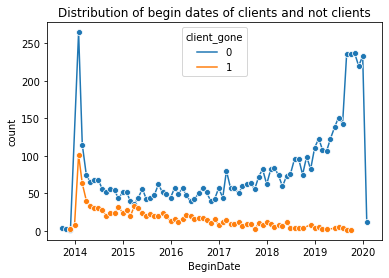

In [46]:
grouped = common.groupby(['BeginDate', 'client_gone']).size().reset_index(name='count')
sns.lineplot(data=grouped, x='BeginDate', y='count', hue='client_gone', marker='o')
plt.title('Distribution of begin dates of clients and not clients')
plt.show()

Клиенты, зарегистрировавшиеся в 2014 были недовольны компанией больше всего, в последние годы количество людей, отказывающихся от услуг компании, падает, а кол-во новых пользователей растет

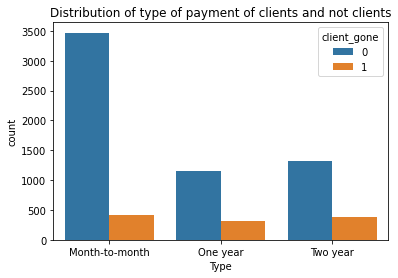

In [47]:
sns.countplot(data=common,x='Type',hue='client_gone')
plt.title('Distribution of type of payment of clients and not clients')
plt.show()

У ушедших клиентов разница в типах оплаты почти незаметна, а у действующих наиболее популярен помесячный тип оплаты

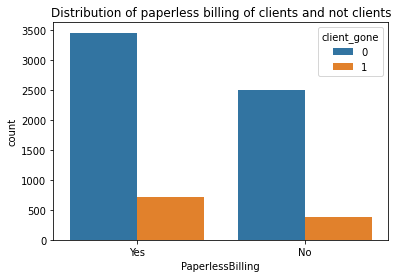

In [48]:
sns.countplot(data=common,x='PaperlessBilling',hue='client_gone')
plt.title('Distribution of paperless billing of clients and not clients')
plt.show()

Большинство клиентов обоих типов соглашаются на расчетный лист

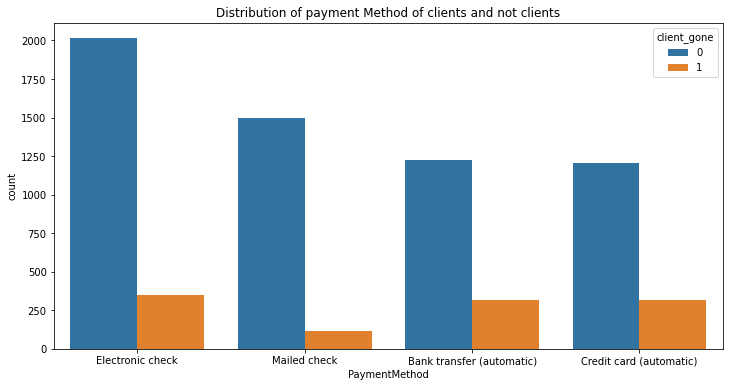

In [49]:
plt.figure(figsize=(12, 6))
sns.countplot(data=common,x='PaymentMethod',hue='client_gone')
plt.title('Distribution of payment Method of clients and not clients')
plt.show()

Ушедшие клиенты реже всего пользовались чеком по почте, у действующих же клиентов такое случается гораздо чаще.

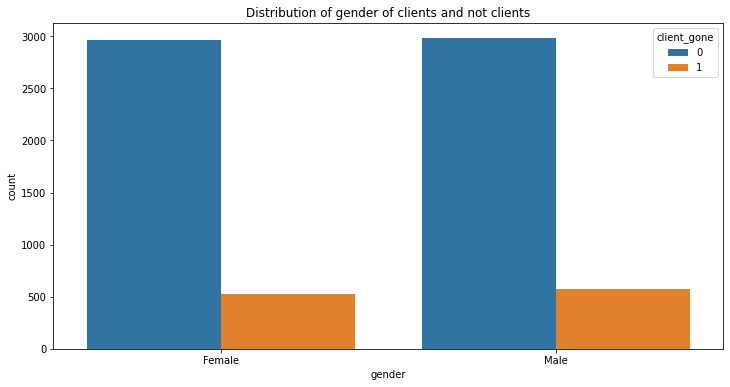

In [50]:
plt.figure(figsize=(12, 6))
sns.countplot(data=common,x='gender',hue='client_gone')
plt.title('Distribution of gender of clients and not clients')
plt.show()

Мужчин в целом больше, как среди действующих клиентов, так и среди ушедших

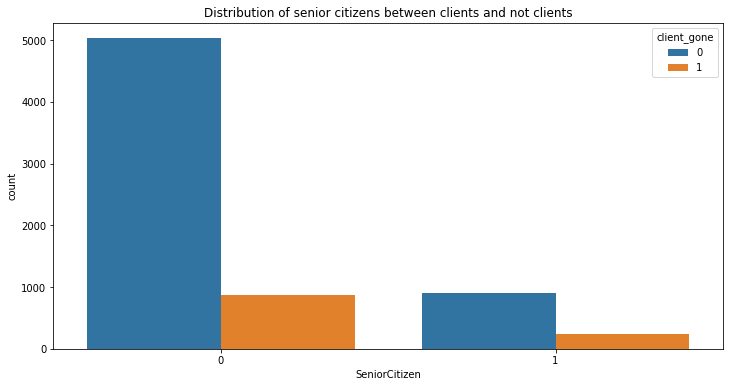

In [51]:
plt.figure(figsize=(12, 6))
grouped = common.groupby(['SeniorCitizen', 'client_gone']).size().reset_index(name='count')
sns.barplot(data=grouped,x='SeniorCitizen',y='count',hue='client_gone')
plt.title('Distribution of senior citizens between clients and not clients')
plt.show()

Пенсионеров в целом меньше, как среди действующих клиентов, так и среди ушедших

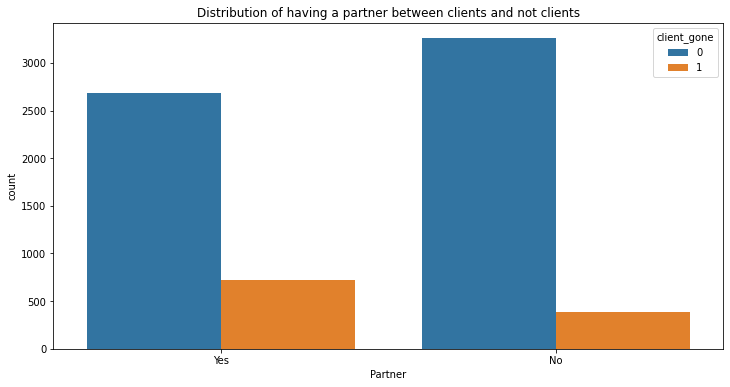

In [52]:
plt.figure(figsize=(12, 6))
sns.countplot(data=common,x='Partner',hue='client_gone')
plt.title('Distribution of having a partner between clients and not clients')
plt.show()

У ушедших клиентов чаще был муж/жена, чем у действующих пользователей

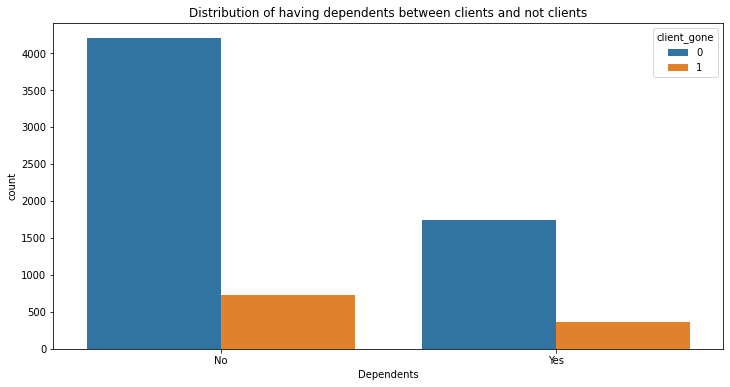

In [53]:
plt.figure(figsize=(12, 6))
sns.countplot(data=common,x='Dependents',hue='client_gone')
plt.title('Distribution of having dependents between clients and not clients')
plt.show()

Детей имеет большая часть клиентов: как ушедших, так и оставшихся

In [54]:
def graphik2(data,x,axes,hue):
    sns.countplot(ax=axes,data=data,x=x,hue=hue)

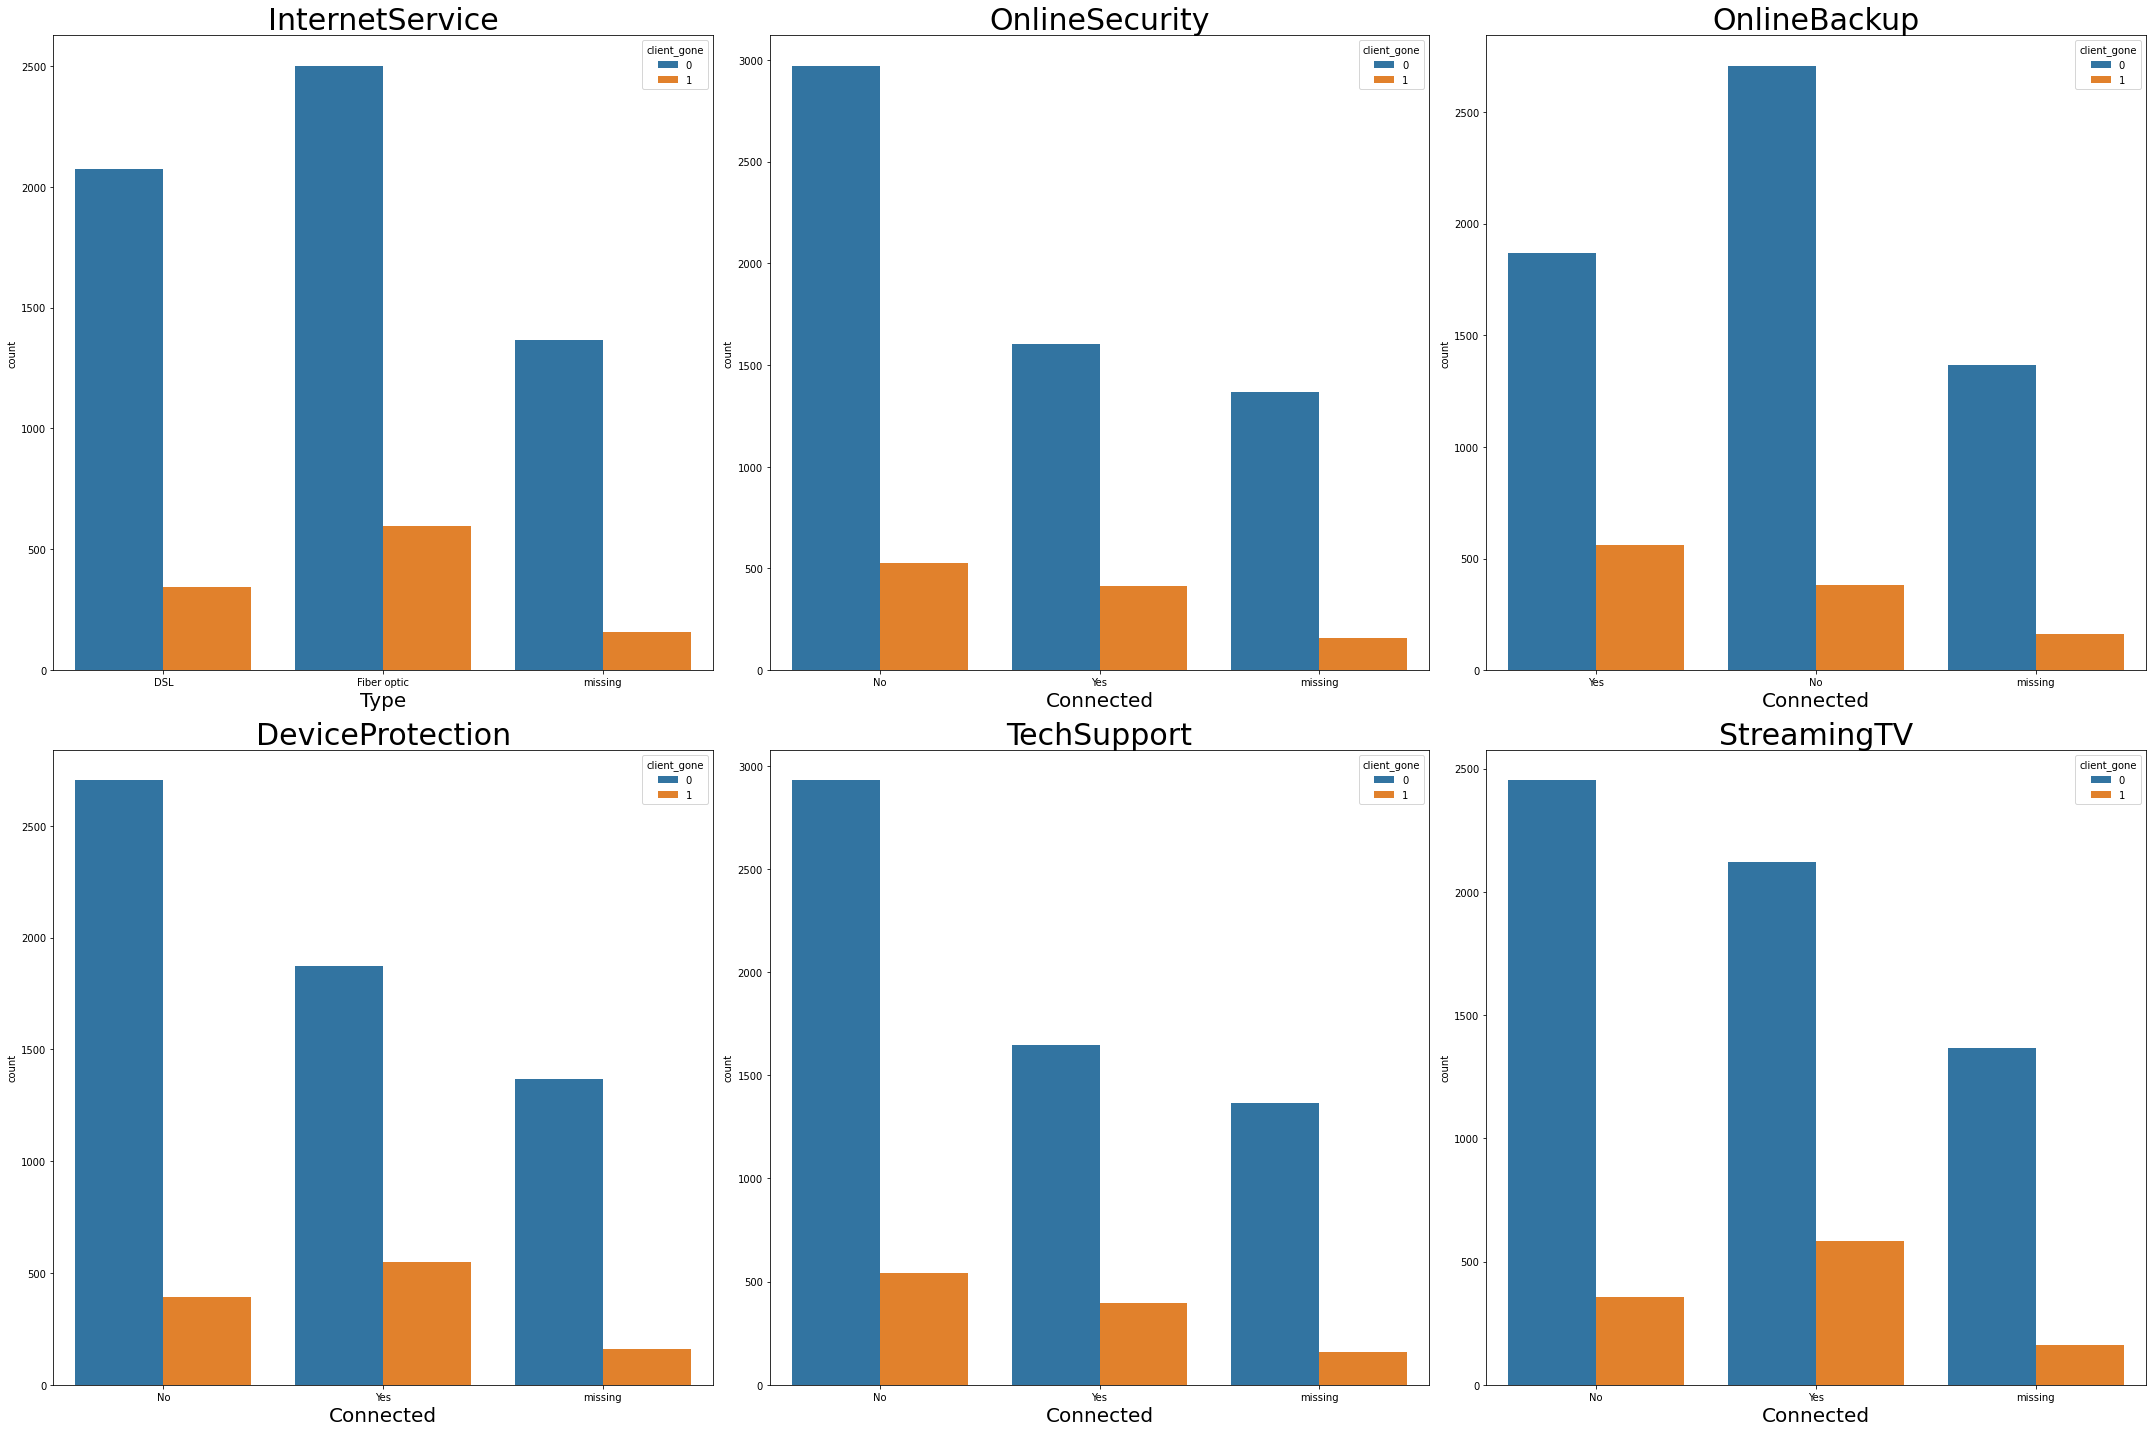

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
axes = axes.flatten()
features=internet.drop(columns=['customerID','StreamingMovies']).columns
for i,feature in enumerate(features):
    graphik2(common,feature,axes[i],'client_gone')
    axes[i].set_title(feature,fontsize=30)
    if feature=='InternetService':
        axes[i].set_xlabel("Type",fontsize=20)
        continue
    axes[i].set_xlabel("Connected",fontsize=20)
plt.tight_layout() 
plt.show()

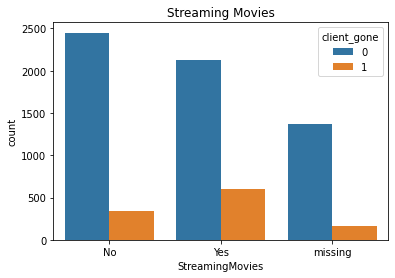

In [56]:
sns.countplot(data=common,x='StreamingMovies',hue='client_gone')
plt.title('Streaming Movies')
plt.show()

Ушедшие клиенты чаще всего пользовались интернетом через оптоволоконный кабель- вероятно это и могло стать одной из причин отказа от дальнейшего сотрудничества.
    
Ушедшие клиенты также пользовались антивирусом, блокировкой небезопасных сайтов, выделенной линией технической поддержки, облачным хранилищем файлов для резервного копирования данных и стриминговым телевидением в среднем чаще, чем действующие клиенты

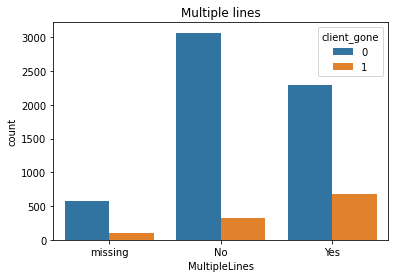

In [57]:
sns.countplot(data=common,x='MultipleLines',hue='client_gone')
plt.title('Multiple lines')
plt.show()

Ушедшие клиенты чаще пользовались услугой подключения телефона к нескольким линиям одновременно.

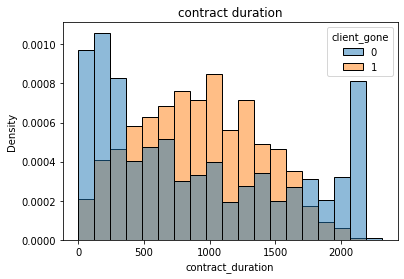

In [58]:
sns.histplot(data=common,x='contract_duration',hue='client_gone',stat='density',common_norm=False)
plt.title('contract duration')
plt.show()

Длительность контракта у ушедших пользователей распределена нормально, а у действующих клиентов- биимодально, больше всего в датасете тех, кто только недавно заключил договор и тех, кто пользуется услугами уже 6+лет

## Подготовка данных

Исключу из признаков customerID из-за бесполезности и client_gone из-за утечки целевого признака, также удалю MonthlyCharges из-за мультиколлинеарности с TotalCharges. BeginDate и EndDate тоже не особо нужны.

In [59]:
X=common.drop(['customerID','client_gone','MonthlyCharges','BeginDate','EndDate'],axis=1)
y=common['client_gone']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

In [61]:
ord_columns=X_train.drop(['TotalCharges','contract_duration'],axis=1).columns
ohe_columns=X_train.drop(['TotalCharges','contract_duration'],axis=1).columns
num_columns=['TotalCharges','contract_duration']

## Обучение модели

In [62]:
ord_pipe=Pipeline([
    ('SimpleImputer_before_ord',SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('ord',OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan
)),
    ('SimpleImputer_after_ord',SimpleImputer(missing_values=np.nan,strategy='most_frequent'))
])
data_preprocessor=ColumnTransformer([
    ('ord',ord_pipe,ord_columns),
    ('num',StandardScaler(),num_columns)],
    remainder='passthrough'
)

In [63]:
pipe_final=Pipeline([
    ('preprocessor',data_preprocessor),
    ('models',DecisionTreeClassifier(random_state=RANDOM_STATE))
])
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2,10),
        'models__min_samples_leaf': range(2,10)
    },
    {
        'models':[CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.1, 0.5, 1]
    }
    
]

In [64]:
grid=GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=3,
    refit='roc_auc',
    scoring='roc_auc',
    error_score='raise'
)

In [65]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 68 candidates, totalling 340 fits
[CV 1/5] END models=DecisionTreeClassifier(random_state=20625), models__min_samples_leaf=2, models__min_samples_split=2;, score=0.655 total time=   0.1s
[CV 2/5] END models=DecisionTreeClassifier(random_state=20625), models__min_samples_leaf=2, models__min_samples_split=2;, score=0.642 total time=   0.1s
[CV 3/5] END models=DecisionTreeClassifier(random_state=20625), models__min_samples_leaf=2, models__min_samples_split=2;, score=0.685 total time=   0.1s
[CV 4/5] END models=DecisionTreeClassifier(random_state=20625), models__min_samples_leaf=2, models__min_samples_split=2;, score=0.647 total time=   0.1s
[CV 5/5] END models=DecisionTreeClassifier(random_state=20625), models__min_samples_leaf=2, models__min_samples_split=2;, score=0.654 total time=   0.1s
[CV 1/5] END models=DecisionTreeClassifier(random_state=20625), models__min_samples_leaf=2, models__min_samples_split=3;, score=0.655 total time=   0.1s
[CV 2/5] END models=

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('SimpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('SimpleImputer_after_ord',
                                                                                          SimpleImputer(stra...
                                        DecisionTreeClassifier(random_state=20625))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeClassifier(random_state=20625)],
                          'models__min_samples_leaf': range(2, 10),
                          'models__min_samples_split': range(2, 10)},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7ff2588c19a0>],
                          'models__learning_rate': [0.01, 0.1, 0.5, 1]}],
             refit='roc_auc', scoring='roc_auc', verbose=3)

In [66]:
print('Лучшая среди древесных и бустинговых модель и её параметры:\n\n', grid.best_estimator_) 
print ('Метрика лучшей модели, полученная с помощью кросс-валидации:', grid.best_score_)

Лучшая среди древесных и бустинговых модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Type', 'Paperles...g', 'Pa

In [67]:
ohe_pipe=Pipeline([
    ('simpleImputerohe',SimpleImputer(missing_values=np.nan ,strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore'))
])
data_preprocessor_linear=ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
    ('num',StandardScaler(),num_columns)],
    remainder='passthrough'
)
pipe_linear=Pipeline([
    ('preprocessor',data_preprocessor_linear),
    ('models',LogisticRegression(random_state=RANDOM_STATE))
])
param_linear = [{
        'models':[LogisticRegression(random_state=RANDOM_STATE)],
        'models__C':[0.1,0.5,1,5,10]
}]

In [68]:
grid_linear=GridSearchCV(
    pipe_linear,
    param_linear,
    cv=5,
    n_jobs=-1,
    verbose=3,
    refit='roc_auc',
    scoring='roc_auc',
    error_score='raise'
)

In [69]:
grid_linear.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END models=LogisticRegression(random_state=20625), models__C=0.1;, score=0.761 total time=   0.5s
[CV 2/5] END models=LogisticRegression(random_state=20625), models__C=0.1;, score=0.764 total time=   0.5s
[CV 3/5] END models=LogisticRegression(random_state=20625), models__C=0.1;, score=0.783 total time=   0.6s
[CV 4/5] END models=LogisticRegression(random_state=20625), models__C=0.1;, score=0.756 total time=   0.5s
[CV 5/5] END models=LogisticRegression(random_state=20625), models__C=0.1;, score=0.783 total time=   0.5s
[CV 1/5] END models=LogisticRegression(random_state=20625), models__C=0.5;, score=0.763 total time=   0.5s
[CV 2/5] END models=LogisticRegression(random_state=20625), models__C=0.5;, score=0.762 total time=   0.5s
[CV 3/5] END models=LogisticRegression(random_state=20625), models__C=0.5;, score=0.786 total time=   0.6s
[CV 4/5] END models=LogisticRegression(random_state=20625), models__C=0.5;, score=0.

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputerohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCit...
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['TotalCharges',
                                                                          'contract_duration'])])),
                                       ('models',
                                        LogisticRegression(random_state=20625))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(random_state=20625)],
                          'models__C': [0.1, 0.5, 1, 5, 10]}],
             refit='roc_auc', scoring='roc_auc', verbose=3)

In [70]:
print('Лучшая среди линейных модель и её параметры:\n\n', grid_linear.best_estimator_) 
print ('Метрика лучшей модели, полученная с помощью кросс-валидации:', grid_linear.best_score_)

Лучшая среди линейных модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputerohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='

In [71]:
y_pred=grid.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.9154068273583752

Проверю свою модель на адекватность и сравню с моделью dummyclassifier

In [72]:
dummy_regr = DummyClassifier(strategy="prior")
X=pipe_final.named_steps['preprocessor'].fit_transform(X_train)
dummy_regr.fit(X, y_train)
y_dummy=dummy_regr.predict(X_test)
print('Метрика roc-auc константной модели на тестовой выборке: ',roc_auc_score(y_test,y_dummy))

Метрика roc-auc константной модели на тестовой выборке:  0.5


In [73]:
y_pred2=grid.predict(X_test)
print('Метрика accuracy на тестовой выборке: ',accuracy_score(y_test,y_pred2))

Метрика accuracy на тестовой выборке:  0.9239068710959683


В среднем наша модель предсказывает верно 92% данных, однако стоит учитывать, что мы имеем дело с дисбалансом классов, поэтому метрика accuracy не сможет адекватно оценить нашу модель, ведь наша модель может просто присваивать всем подряд статус действующего клиента и благодаря дисбалансу классов будет выдавать правильные значения гораздо чаще, чем неправильные, а нам необходимо, чтобы она как можно правильнее классифицировала всех потенциально уходящих клиентов

### Анализ важности признаков

In [74]:
X_train_shap = pd.DataFrame(pipe_final.named_steps['preprocessor'].fit_transform(X_train), 
                            columns=pipe_final.named_steps['preprocessor'].get_feature_names_out())

X_test_shap = pd.DataFrame(pipe_final.named_steps['preprocessor'].transform(X_test), 
                           columns=pipe_final.named_steps['preprocessor'].get_feature_names_out())

explainer = shap.KernelExplainer(grid.best_estimator_.named_steps['models'].predict_proba, X_train_shap[:100])
shap_values = explainer(X_test_shap[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

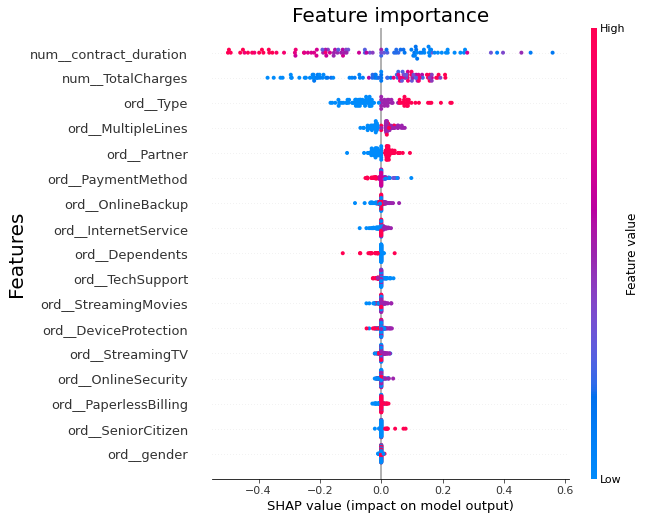

In [75]:
fig, ax = plt.gcf(), plt.gca()
ax.set_title('Feature importance',fontsize=20)
ax.set_ylabel('Features',fontsize=20)
columns=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 
try:
    shap_values.feature_names=columns
except:
    explainer.data_feature_names=columns
shap.plots.beeswarm(shap_values[:, :, 1], max_display=25)


Наибольшее влияние оказывают два признака- это BeginYear и TotalCharges, если пользователь недавно зарегистрировался и суммарно потратил много денег на услуги, вероятнее всего он вряд ли откажется от пользования услуг компании. Также можно заметить, что те, кто пользуются оптоволокнами, склонны чаще отказываться от услуг "Теледома"

Большое значение в признаке contract duration говорит о том, что клиент скорее всего не будет прекращать пользоваться услугами, также большое значение в столбце TotalCharges повышает шанс того, что клиент скоро прекратит быть пользователем услуг ТелеДома. Отсутствие дополнительных услуг(MultipleLines,OnlineBackup,InternetService) позволяет удержать клиента дольше

In [76]:
feature_results = pd.DataFrame({
    "feature":common.drop(['customerID','client_gone','MonthlyCharges','BeginDate','EndDate'],axis=1).columns,
    "importance": grid.best_estimator_._final_estimator.feature_importances_
})
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)
feature_results

,feature,importance
0,contract_duration,41.569243
1,MultipleLines,12.168442
2,Type,7.941385
3,PaymentMethod,4.821370
4,StreamingMovies,4.342184
5,SeniorCitizen,3.460719
6,OnlineSecurity,3.093797
7,StreamingTV,3.073953
8,TechSupport,2.614062
9,OnlineBackup,2.554227


Наибольшее влияние на целевой признак оказывает contract_duration- отрыв от ближайшего преследователя больше, чем в 3 раза. Также большое влияние имеют признаки Type и MultipleLines. Можно сделать вывод, что чем дольше клиент пользуется услугами компании, тем меньше вероятность, что он перестанет это делать

### Матрица ошибок

In [77]:
y_pred= grid.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
specificity = specificity_score(y_test,y_pred)
print('accuracy: ',round(acc,3))
print('recall: ',round(recall,3))
print('precision: ',round(precision,3))
print('specificity: ',round(specificity,3))

accuracy:  0.924
recall:  0.615
precision:  0.858
specificity:  0.981


Замечу, что нам нужно максимизировать метрику Recall, поскольку необходимо выявить какая доля из собирающихся отказаться от услуг будет действительно определена

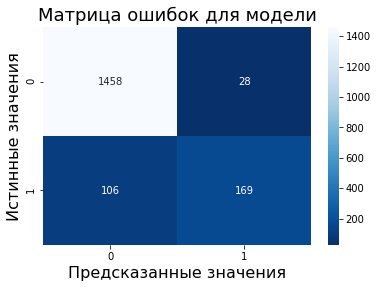

In [78]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок для модели', fontsize=18)
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.show()

Всего модель определила 92% клиентов правильно (метрика accuracy), то есть 92% клиентов были распознаны верно
    
61.5% уходящих клиентов смогла определить модель (метрика recall). 169 человек она верно определила, как уходящих, и еще 106 человек классифицировала как действующих, хотя на самом деле они расторгли договор
    
85.8% всех предсказанных моделью уходящих клиентов действительно были уходящими(метрика precision).169 человек она верно определила как уходящих, и еще 28 человек определила как уходящие, хотя на самом деле они действующие
    
98.1% всех действующих клиентов модель определила верно(метрика specifity).1458 человек она верно определила, как остающихся и еще 28 человек определила как уходящие, хотя на самом деле они действующие

## Выводы и рекомендации

Был произведен визуальный осмотр данных, статистической информации, проверка на пропуски и дубликаты. Был проведен статистический анализ каждого признака из каждого датафрейма. Затем было произведено объединение датасетов по общему ключу, был выявлен целевой признак. В общем датасете был проведен еще один статистический анализ, благодаря которому можно было увидеть распределение каждого признака по целевому. Также была построена матрица корреляции для отображения зависимостей между признаками. Затем была выполнена подготовка данных, создан пайплайн с тремя моделями, в котором благодаря кросс-валидации была получена лучшая модель CatBoostClassifier, достигшая метрики roc-auc на тестовой выборке 0.929. Также была проанализирована матрица ошибок. Значение accuracy составляет 0.918, значение recall 0.535, значение precision 0.9 и значение specifity 0.989

1.Изучить конкурентов, их услуги и предлагаемые продукты, чтобы следить за трендами и понимать, что нужно клиентам
 
2.На основе полученных в ходе исследовательского анализа данных выявлено, что средние общие расходы ушедших клиентов меньше, чем у оставшихся абонентов, однако в месяц они тратили больше, чем оставшиеся.  Возможно, ушедших клиентов не устраивало количество и стоимость дополнительных услуг, которых нет у действующих абонентов. Так, можно предложить клиентам с большим количеством дополнительных услуг снижение стоимости на одну из них, или подключение новой бесплатной услуги. Было выявлено, что если клиент заключил договор давно, то вероятнее всего он планирует отказаться от услуг в дальнейшем, поэтому можно предложить клиентам, которые пользуются услугами компании уже давно, какие-либо маленькие подарки за преданность бренду.
 
3.Можно наладить действую и эффективную систему коммуникаций с клиентами, которая позволит проводить опросы и исследования, а также вовлекать клиентов в работу с продуктом, для раннего выявления проблем и предотвращать отток абонентов.
 
4.Судя по тому, что большинство пользователей использует помесячную оплату, организации можно изменить политику долгосрочных контрактов и сделать её дешевле(например при заключении контракта на год, цена за месяц будет меньше, чем при заключении месячного контракта).Это позволило бы привлекать клиента на более долгий срок
 
5.Подключение соединения через оптоволоконный кабель имеет какие-то проблемы, поскольку, как показал анализ признаков, пользователи с этим типом подключения более склонны к тому, чтобы отказаться от услуг компании. Организации следует проверить, все ли в порядке с данной услугой, чтобы не терять клиентов, недовольных качеством предоставляемого интернета